In [1]:
import numpy as np
import glob
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import re
import scipy.stats

In [2]:
# inputDirs = {
#     'fbp': '../../train/recon/fbp_fp/', 
#     'tv': '../../train/recon/tv_fp/4e-5/', 
#     'nlm': '../../train/recon/nlm_fp/7.5e-4_sigma_0.05/', 
#     'dict': '../../train/recon/csc_fp/0.02/', 
#     'n2n(d)': '../../train/recon/n2n_fp/denoising/2/', 
#     'n2n': '../../train/recon/n2n_fp/7.5e-4/', 
#     'n2c': '../../train/recon/n2c_fp/unet/final', 
# }

inputDirs = {
    'Gaussian': '../../train/recon/gaussian_2d/1.25e-4/', 
    'TV': '../../train/recon/tv_2d/4e-5/', 
    'NLM': '../../train/recon/nlm_2d/5e-4_sigma_0.075/', 
    'CSC': '../../train/recon/csc_2d/0.02/', 
    'N2N$_d$': '../../train/recon/n2n_denoising_2d/denoising/2/', 
    'N2N$_r$\n(w/o pre)': '../../train/recon/n2n_2d/encoder_decoder_all_no_init/7.5e-4/', 
    '$\mathbf{N2N}_r$': '../../train/recon/n2n_2d/encoder_decoder_all/7.5e-4/', 
#     'n2n(admm)': '../../train/recon/n2n_2d/admm/encoder_decoder_all/7.5e-4/', 
    'N2C': '../../train/recon/n2c_2d/encoder_decoder/final/'
}

In [3]:
rmseAll = {}

for k in inputDirs:
    iSlices = []
    rmses = []
    subDirs = glob.glob(os.path.join(inputDirs[k], '*'))
    
    for subDir in subDirs:
        if os.path.basename(subDir).isdigit():
            iSlices.append(int(os.path.basename(subDir)))
            
            loss = np.load(os.path.join(subDir, 'loss.npz'))['val']
            if loss.ndim == 0:
                rmses.append(float(loss))
            else:
                rmses.append(loss[-1,-1])
    
    ind = np.argsort(iSlices)
    rmses = np.array(rmses)[ind]
    
    rmseAll[k] = rmses

In [4]:
for k in rmseAll:
    print ('%s: %g, %g'%(k, np.mean(rmseAll[k]), np.std(rmseAll[k])))

Gaussian: 0.0251267, 0.00569655
TV: 0.0236619, 0.0046505
NLV: 0.0217647, 0.00445209
CSC: 0.0205578, 0.00512551
N2N$_d$: 0.0226006, 0.00465293
N2N$_r$
(w/o pre): 0.0188228, 0.00392337
$\mathbf{N2N}_r$: 0.0185193, 0.00395835
N2C: 0.0175881, 0.00461469


In [5]:
for k in rmseAll:
    if k != '$\mathbf{N2N}_r$':
        _, pVal = scipy.stats.ttest_rel(rmseAll['$\mathbf{N2N}_r$'], rmseAll[k])
        print (k, pVal)

Gaussian 4.2218366671677545e-45
TV 7.06572218250529e-47
NLV 4.4172694849760214e-27
CSC 2.8677444747652838e-22
N2N$_d$ 1.2166171334716106e-54
N2N$_r$
(w/o pre) 5.014373929556562e-20
N2C 2.1631232185610413e-07


In [27]:
def SetBPlotColor(bplot, color):
    for patch in bplot['boxes']:
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('black')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


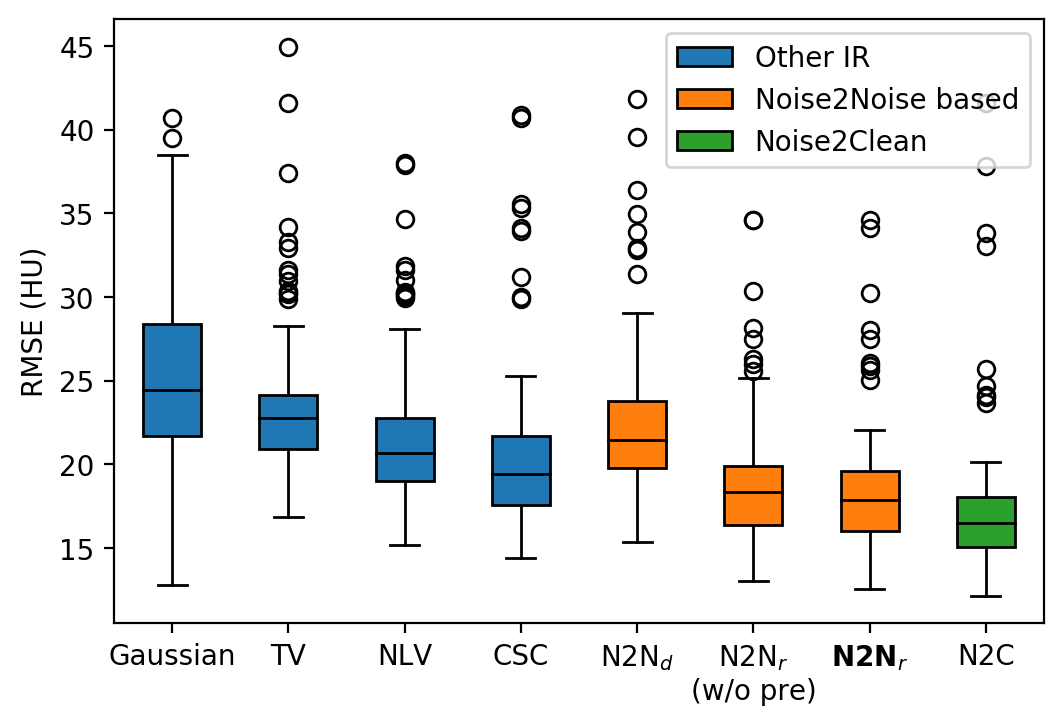

In [29]:
# boxplot
vals = []
for k in rmseAll:
    vals.append(rmseAll[k])
vals = np.array(vals)


groups = [[0,1,2,3], [4,5,6], [7]]
colorList = plt.rcParams['axes.prop_cycle'].by_key()['color']
bplots = []
plt.figure(figsize=[6,4], dpi=200)
for i, group in enumerate(groups):
    bplot = plt.boxplot(vals[group,:].T * 1000, positions=range(group[0]+1,group[-1]+2), widths=0.5, patch_artist=True)
    SetBPlotColor(bplot, colorList[i])
    bplots.append(bplot)
plt.xticks(range(1,len(rmseAll)+1), list(rmseAll.keys()))
plt.ylabel('RMSE (HU)')
plt.legend([bplot['boxes'][0] for bplot in bplots], ['Other IR', 'Noise2Noise based', 'Noise2Clean'])

plt.savefig('../../train/recon/eval/rmse.eps')